# **A Deep Learning Approach for Intrusion Detection Using Recurrent Neural Networks**



> Multiclass-5 classes(4 Attack and Normal), KDDTest_21



In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

In [2]:
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from keras.layers import SimpleRNN

In [3]:
## add the columns' name and read the KDDTrain+ and KDDTest+ datasets
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

print(col_names)


['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']


## Dataset
The dataset covers the **KDDTrain** dataset as the training set and **KDDTest** and **KDDTest−21** datasets as the testing set, normal records and four different types of attack records.

In [4]:
#Training set
df = pd.read_csv("Dataset/NSL_KDD_Train.csv",header=None, names = col_names)
# Testing set
df_test_21 = pd.read_csv("Dataset/NSL_KDD_Test_21.csv", header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test_21 set:',df_test_21.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test_21 set: (11850, 42)


In [5]:
# review the features type
df.head(5) 

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [6]:
df_test_21.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,13,tcp,telnet,SF,118,2425,0,0,0,0,...,10,0.38,0.12,0.04,0.0,0.00,0.00,0.12,0.3,guess_passwd
1,0,udp,private,SF,44,0,0,0,0,0,...,254,1.00,0.01,0.01,0.0,0.00,0.00,0.00,0.0,snmpguess
2,0,tcp,telnet,S3,0,44,0,0,0,0,...,79,0.31,0.61,0.00,0.0,0.21,0.68,0.60,0.0,processtable
3,0,udp,private,SF,53,55,0,0,0,0,...,255,1.00,0.00,0.87,0.0,0.00,0.00,0.00,0.0,normal
4,0,tcp,private,SH,0,0,0,0,0,0,...,1,0.06,1.00,1.00,0.0,1.00,1.00,0.00,0.0,nmap


In [7]:
print("Training dim: ",df.shape)
print("Testing dim: ",df_test_21.shape)

Training dim:  (125973, 42)
Testing dim:  (11850, 42)


In [8]:
print('Label distribution in the Training set:')
print("****************************************")
print(df['label'].value_counts())
print('\n')
print('Label distribution in the Test set:')
print("**************************************")
print(df_test_21['label'].value_counts())

Label distribution in the Training set:
****************************************
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


Label distribution in the Test set:
**************************************
normal             2152
neptune            1579
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               727
processtable        685
smurf               627
back                359
s

<AxesSubplot:>

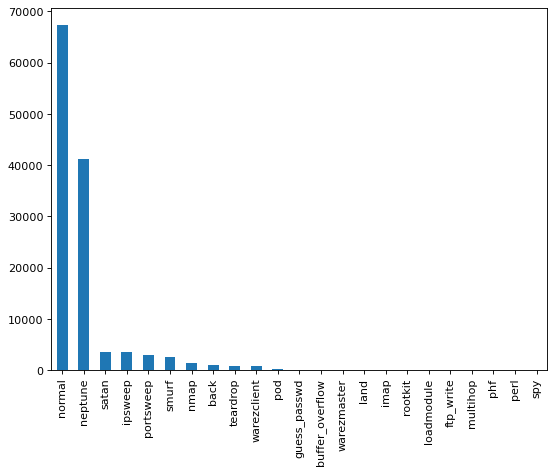

In [9]:
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

df['label'].value_counts().plot(kind='bar')

# **Step 1: Data preprocessing:**

One-Hot-Encoding is used to convert all categorical properties to binary properties. One-Hot-Endcoding requirement, the input to this transformer must be an integer matrix expressing values taken with categorical (discrete) properties. The output will be a sparse matrix in which each column corresponds to a possible value. It is assumed that the input properties have values in the range [0, n_values]. Therefore, to convert each category to a number, properties must first be converted with LabelEncoder.

In [10]:
# columns are categorical, not yet binary: protocol_type (column 2), service (column 3), flag (column 4).
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [11]:
# Test set
print('Test set:')
for col_name in df_test_21.columns:
    if df_test_21[col_name].dtypes == 'object' :
        unique_cat = len(df_test_21[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 62 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


**LabelEncoder**

**Insert categorical features into a 2D numpy array**

In [12]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
# for Test
testdf_categorical_values = df_test_21[categorical_columns]

In [13]:
# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test_21.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

**Transform categorical features into numbers using LabelEncoder()**

In [14]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


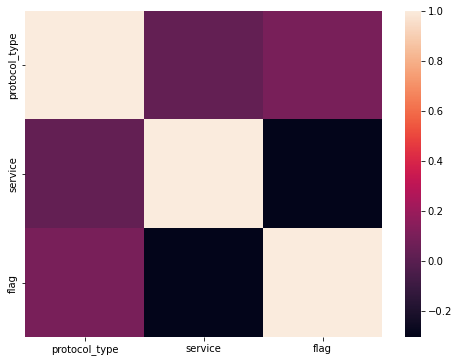

In [15]:
corr = df_categorical_values_enc.corr()
plt.figure(figsize=(8,6))
sb.heatmap(corr)
plt.show()

**One-Hot-Encoding**

In [16]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

Missing columns in test set are added 




In [17]:
trainservice=df['service'].tolist()
testservice= df_test_21['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]

for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)    
print(testdf_cat_data.shape)

(125973, 84)
(11850, 84)


New numeric columns are added to main dataframe

In [18]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test_21.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(11850, 123)


**Feature Scaling**

In [19]:
# step1: apply the logarithmic scaling method for scaling to obtain the ranges of `duration[0,4.77]', `src_bytes[0,9.11]' and `dst_bytes[0,9.11]
newdf['log2_value1'] = np.log2(newdf['duration'])
newdf['log2_value2'] = np.log(newdf['src_bytes'])
newdf['log2_value3'] = np.log(newdf['dst_bytes'])
newdf=newdf.drop(['log2_value3','log2_value2','log2_value1'], axis=1)


# testing set

newdf_test['log2_value1'] = np.log2(newdf_test['duration'])
newdf_test['log2_value2'] = np.log(newdf_test['src_bytes'])
newdf_test['log2_value3'] = np.log(newdf_test['dst_bytes'])
newdf_test=newdf_test.drop(['log2_value3','log2_value2','log2_value1'], axis=1)

print(newdf)
print(newdf_test)

C:\Users\ASWIN\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\ASWIN\anaconda3\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0              0        491          0     0               0       0    0   
1              0        146          0     0               0       0    0   
2              0          0          0     0               0       0    0   
3              0        232       8153     0               0       0    0   
4              0        199        420     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
125968         0          0          0     0               0       0    0   
125969         8        105        145     0               0       0    0   
125970         0       2231        384     0               0       0    0   
125971         0          0          0     0               0       0    0   
125972         0        151          0     0               0       0    0   

        num_failed_logins  logged_in  num_compromised  ...  flag_REJ  \
0  

# Further steps:
**for binary classification**
- Normal - 0
- Anomaly - 1,2,3,4

**for multiclass classification**
proceed with the classes of 0,1,2,3,4

The dataset was divided into separate datasets for each attack category. Attack tags have been renamed for each. 0 = Normal, 1 = DoS, 2 = Probe, 3 = R2L, 4 = U2R. In the new datasets, the tag column has been replaced with the new values.

In [20]:
labeldf=newdf['label']
labeldf_test=newdf_test['label']


# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                            'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



#put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [21]:
newdf.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,146,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,232,8153,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,199,420,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
newdf_test.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_SF,flag_SH,service_http_8001,service_aol,service_printer,service_urh_i,service_harvest,service_http_2784,service_rje,service_red_i
0,13,118,2425,0,0,0,0,0,1,0,...,1.0,0.0,0,0,0,0,0,0,0,0
1,0,44,0,0,0,0,0,0,0,0,...,1.0,0.0,0,0,0,0,0,0,0,0
2,0,0,44,0,0,0,0,0,0,0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,0,53,55,0,0,0,0,0,0,0,...,1.0,0.0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0.0,1.0,0,0,0,0,0,0,0,0


In [23]:
#Split the test and train data into training and testing 
# train set:
x=newdf.drop(["label"],1)  # features
y=newlabeldf  # label
# test set:
xtest=newdf_test.drop(['label'],1) # features
ytest=newlabeldf_test # label

C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\1207078613.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  x=newdf.drop(["label"],1)  # features
C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\1207078613.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  xtest=newdf_test.drop(['label'],1) # features


In [24]:
print("X: ",x.shape)
print("Y: ",y.shape)

X:  (125973, 122)
Y:  (125973,)


In [25]:
print("X: ",xtest.shape)
print("Y: ",ytest.shape)

X:  (11850, 122)
Y:  (11850,)


## Min max normalization

In [26]:
# scaling
scale = MinMaxScaler()
scale = preprocessing.StandardScaler().fit(x)
X_train_scaled=scale.transform(x)
print(X_train_scaled)

[[-0.11024922 -0.0076786  -0.00491864 ... -0.01972622  0.82515007
  -0.04643159]
 [-0.11024922 -0.00773737 -0.00491864 ... -0.01972622  0.82515007
  -0.04643159]
 [-0.11024922 -0.00776224 -0.00491864 ... -0.01972622 -1.21190076
  -0.04643159]
 ...
 [-0.11024922 -0.00738219 -0.00482315 ... -0.01972622  0.82515007
  -0.04643159]
 [-0.11024922 -0.00776224 -0.00491864 ... -0.01972622 -1.21190076
  -0.04643159]
 [-0.11024922 -0.00773652 -0.00491864 ... -0.01972622  0.82515007
  -0.04643159]]


In [27]:
# scaling
scale = MinMaxScaler()
scale = preprocessing.StandardScaler().fit(xtest)
X_test_scaled=scale.transform(xtest)
print(X_test_scaled)

[[-0.2096739  -0.02966205  0.05008971 ...  0.          0.
   0.        ]
 [-0.21644699 -0.02977555 -0.05139586 ...  0.          0.
   0.        ]
 [-0.21644699 -0.02984304 -0.04955447 ...  0.          0.
   0.        ]
 ...
 [-0.21592598 -0.02984304 -0.05076811 ...  0.          0.
   0.        ]
 [-0.21644699 -0.02984304 -0.05139586 ...  0.          0.
   0.        ]
 [-0.21644699 -0.02978016 -0.05139586 ...  0.          0.
   0.        ]]


## Building the RNN model

In [28]:
from tensorflow import keras
import numpy as np
import datetime
import time

sample = X_train_scaled.shape[0]
features = X_train_scaled.shape[1]
#Train: convert 2D to 3D for input RNN
x_train = np.reshape(X_train_scaled,(sample,features,1)) #shape  = (125973, 18, 1)
#Test: convert 2D to 3D for input RNN

x_test = np.reshape(X_test_scaled,(X_test_scaled.shape[0],X_test_scaled.shape[1],1))

In [29]:
print(x_train.shape)
print(y.shape)

(125973, 122, 1)
(125973,)


In [30]:
print(x_test.shape)
print(ytest.shape)

(11850, 122, 1)
(11850,)


# **RNN Model**

### Metrics list to evaluate the model

In [31]:
import tensorflow as tf
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

### Custom Callback functions: recall, precision, f1_score

In [32]:
import tensorflow.keras.backend as K
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true) 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2*((prec*rec)/(prec+rec+K.epsilon()))

In [33]:
from keras import optimizers 
model = Sequential()
model.add(SimpleRNN(80,input_shape=(features,x_train.shape[2]), activation='relu'))
model.add(Dense(5, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy', 'mae', recall,precision,f1_score])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 80)                6560      
                                                                 
 dense (Dense)               (None, 5)                 405       
                                                                 
Total params: 6,965
Trainable params: 6,965
Non-trainable params: 0
_________________________________________________________________


In [34]:
mcp = ModelCheckpoint('RNN_multicalss1.h5')

In [35]:
# multi-class classification
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(60, input_dim=122, activation='relu'))
	model.add(Dense(5, activation='softmax'))
	# Compile model
  
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator,xtest,ytest, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\2842676102.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)


Accuracy: 91.79%


In [36]:
# multi-class classification
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(80, input_dim=122, activation='relu'))
	model.add(Dense(5, activation='softmax'))
	# Compile model
  
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator,xtest,ytest, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\695409880.py:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)


Accuracy: 90.81%


In [37]:
# Step 2: the value of every feature is mapped to the [0,1] range linearly
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
# Training Set
scale = MinMaxScaler()
scale = preprocessing.StandardScaler().fit(x)
x=scale.transform(x)
scaletest = preprocessing.StandardScaler().fit(xtest)
xtest=scaletest.transform(xtest)

In [38]:
to_drop_DoS = [0,1]
to_drop_Probe = [0,2]
to_drop_R2L = [0,3]
to_drop_U2R = [0,4]

# Filter all rows with label value except itself
# isin filter function

DoS_df=newdf[newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[newdf['label'].isin(to_drop_U2R)];



#test
DoS_df_test=newdf_test[newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[newdf_test['label'].isin(to_drop_U2R)];


print('Train Set:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print()
print('Test Set:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train Set:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)

Test Set:
Dimensions of DoS: (6496, 123)
Dimensions of Probe: (4554, 123)
Dimensions of R2L: (5037, 123)
Dimensions of U2R: (2219, 123)


**`Split the training set and testing set`**

In [39]:
# Split dataframes into X & Y
# X Properties, Y result variable

X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label

X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label

X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label

X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label

# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label

X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label

X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label

X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label


C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\2924131433.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_DoS = DoS_df.drop('label',1)
C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\2924131433.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_Probe = Probe_df.drop('label',1)
C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\2924131433.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_R2L = R2L_df.drop('label',1)
C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\2924131433.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_U2R = U2R_df.drop('label',1)
C:\Users\ASWIN\AppData\Local\Temp\ipykernel_9636\2924131433.py:17: FutureW

**Since the column names will be deleted at this stage, we save the column names for later use.**

In [40]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

**Step 2: Feature Scaling**

In [41]:
from sklearn import preprocessing

scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 

scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe)

scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L)

scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 

# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 

scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 

scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 

scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

**Build the Compartive Machine learning Models:**

**DoS**

DoS
     Accuracy Score
MLP        0.724908
SVM        0.624692
NB         0.596059
J48        0.561730
RF         0.331127




Text(0.5, 0, 'DoS')

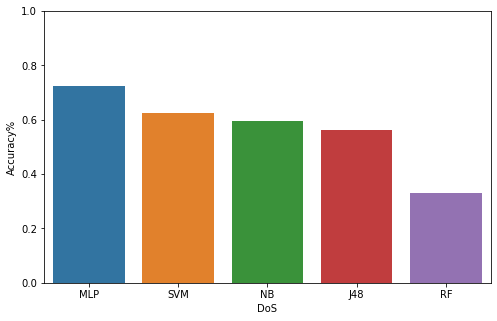

In [42]:
#1. DoS
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt 
import seaborn as sns

mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model = value
    model.fit(X_DoS, Y_DoS.astype(int))
    scores[key] = model.score(X_DoS_test , Y_DoS_test)

# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('DoS')
print(scores_frame)
print("\n")

plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("DoS")

**Probe**

Probe
     Accuracy Score
RF         0.677866
MLP        0.624286
J48        0.528766
SVM        0.464646
NB         0.410848




Text(0.5, 0, 'Probe')

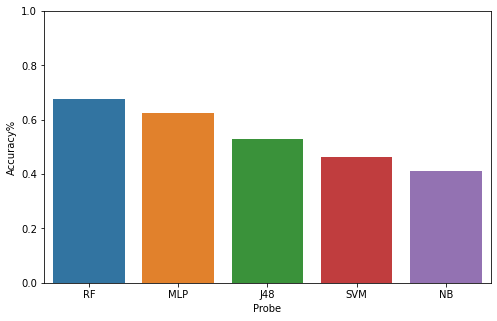

In [43]:
# 2.Probe
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model1 = value
    model1.fit(X_Probe, Y_Probe.astype(int))
    scores[key] = model1.score(X_Probe_test , Y_Probe_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('Probe')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("Probe")

**R2L**

R2L
     Accuracy Score
MLP        0.430018
J48        0.427635
NB         0.427238
RF         0.427238
SVM        0.427238




Text(0.5, 0, 'R2L')

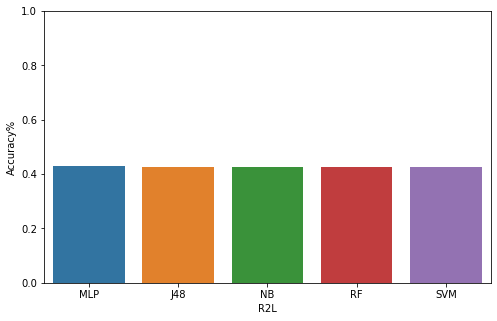

In [44]:
# 3.R2L
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model2 = value
    model2.fit(X_R2L, Y_R2L.astype(int))
    scores[key] = model2.score(X_R2L_test , Y_R2L_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('R2L')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("R2L")

**U2R**

U2R
     Accuracy Score
J48        0.969806
NB         0.969806
RF         0.969806
SVM        0.969806
MLP        0.969356




Text(0.5, 0, 'U2R')

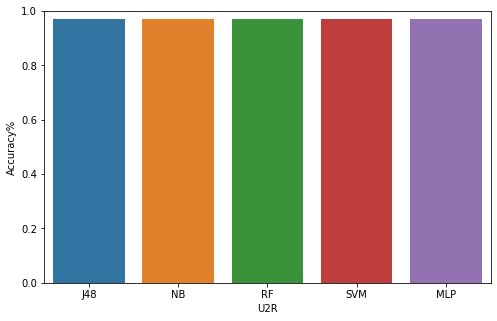

In [45]:
# 4.U2R
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model3 = value
    model3.fit(X_U2R, Y_U2R.astype(int))
    scores[key] = model3.score(X_U2R_test , Y_U2R_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('U2R')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame['Accuracy Score'])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("U2R")

**Step 5: Prediction & Evaluation (validation):**

In [46]:
# 1.DoS
Y_DoS_pred=model.predict(X_DoS_test)
# Create confusion matrix
print('Dos')
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Dos


Predicted attacks,0,1
Actual attacks,,
0,2052,100
1,2338,2006


In [47]:
#2.Probe
Y_Probe_pred=model1.predict(X_Probe_test)

# Create confusion matrix
print('Probe')
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Probe


Predicted attacks,0,2
Actual attacks,,
0,2061,91
2,2347,55


In [48]:
#3.R2L
Y_R2L_pred=model2.predict(X_R2L_test)
# Create confusion matrix
print('R2L')
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

R2L


Predicted attacks,0
Actual attacks,
0,2152
3,2885


In [49]:
#4.U2R
Y_U2R_pred=model3.predict(X_U2R_test)
print('U2R')
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

U2R


Predicted attacks,0
Actual attacks,
0,2152
4,67
